In [1]:
import myutil
import os
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
df = myutil.DataFactory()
# 可視化用に結果の保存先を用意
results = []

# データの調整
* 目的
 * 不要な属性を削除する
 * 組み合わせることでより意味のある属性を追加する
* 目標
 * 推測性能の向上
 * 処理時間の短縮

### 初期状態

In [3]:
data_prepared, data_label = df.getPreparedDataSet()

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_label)
# 訓練データに対して予測値を求める
data_predictions = lin_reg.predict(data_prepared)
# 二乗誤差を求める
lin_mse  = mean_squared_error(data_label, data_predictions)
# 平均二乗誤差を求める
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

69050.98178244587


とりあえずワンホットエンコーディングしておく

In [4]:
data1 = myutil.load_housing_data(os.path.join('datasets', 'housing', 'housing.csv'))
for val in data1['ocean_proximity'].unique():
    data1[val] = data1['ocean_proximity'].where(data1['ocean_proximity'] == val, 0)
    data1[val].where(data1[val]==0, 1, inplace=True)
data1.drop('ocean_proximity', axis=1, inplace=True)
data1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1,0,0,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1,0,0,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1,0,0,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1,0,0,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1,0,0,0,0


## 属性の相対的な重要性の大小を調べる
* RandomForestRegressorの実施　⇒　重要性見てみる

In [5]:
data1_train, data1_test = df.split_dataset(data1)
data1_label, data1_train = df.split_label(data1_train, 'median_house_value')

In [6]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

# 必要最小限のパイプラインの実装
pipeline_min = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_encoder', StandardScaler()),
])

In [7]:
data1_prepared = pipeline_min.fit_transform(data1_train)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble        import RandomForestRegressor

# グリッドサーチ
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(data1_prepared, data1_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [9]:
# 結果を確認する
grid_search.best_params_

{'max_features': 10, 'n_estimators': 30}

In [10]:
# 最良の測定器をとりあえず保存
best_estimator = grid_search.best_estimator_

In [11]:
data1_predictions = best_estimator.predict(data1_prepared)
data1_mse  = mean_squared_error(data1_label, data1_predictions)
data1_rmse = np.sqrt(data1_mse)
result1 = ['data1', data1_rmse]

print(result1)

['data1', 19234.49888783583]


In [12]:
results.append(result1)

In [13]:
# 重要度を確認
feature_importances = best_estimator.feature_importances_
feature_importances

array([1.07077746e-01, 9.94396085e-02, 5.29546036e-02, 2.62966416e-02,
       2.50864544e-02, 3.40959516e-02, 2.31168775e-02, 4.75086643e-01,
       1.19004102e-03, 7.25653557e-03, 1.41389074e-01, 6.90799161e-03,
       1.01831817e-04])

In [14]:
print('size: ', len(list(data1_train)), '\nlist: ' ,list(data1_train))

size:  13 
list:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']


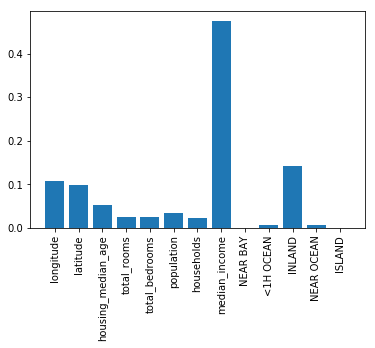

In [15]:
plt.bar(list(data1_train), feature_importances)
plt.xticks(rotation=90)
# plt.yscale("log")
plt.show()

### 考察
* カテゴリ属性
 * 「INLAND」は重要そうな属性
 *  その他の属性は不要そう
* 重要度が低めの属性
 * 「世帯数」「寝室の合計」「部屋数の合計」「人口」「世帯内の年齢の中央値」
 * 組み合わせを考えてみる　⇒　その結果重要度が大きくなれば入れ替えとか
  * 「人口／世帯数」　　　　⇒「１世帯当たりの人数」
  * 「部屋数の合計／世帯数」⇒「１世帯当たりの部屋数」
  * 「寝室の合計／世帯数」　⇒「１世帯当たりの寝室数」
  * 「寝室数／部屋数」　　　⇒「寝室の割合」
  * 「部屋数の合計／人口」　⇒「１人当たりの部屋数」

In [16]:
# とりあえずコピー
data2_train = data1_train.copy()
data2_label = data1_label.copy()

In [17]:
# 不要な属性を落とす
data2_train.drop(['NEAR BAY', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND'], axis=1, inplace=True)

In [18]:
print(list(data2_train))

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'INLAND']


In [19]:
# 複合属性を追加する
data2_train['population_p_households'] = data2_train['population'] / data2_train['households']
data2_train['rooms_p_households'] = data2_train['total_rooms'] / data2_train['households']
data2_train['bedrooms_p_households'] = data2_train['total_bedrooms'] / data2_train['households']
data2_train['bedrooms_p_rooms'] = data2_train['total_bedrooms'] / data2_train['total_rooms']
data2_train['rooms_p_population'] = data2_train['total_rooms'] / data2_train['population']

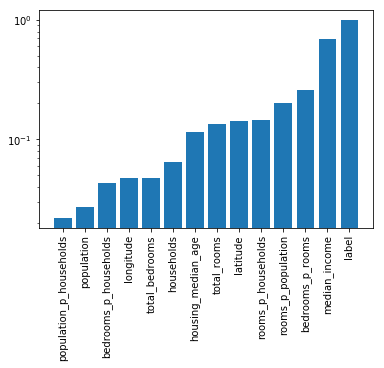

In [20]:
# 相関を見てみる
data2_train['label'] = data2_label
x_label = np.array(list(data2_train))
x_label = np.delete(x_label, np.where(x_label=='INLAND'))
height  = np.array(data2_train.corr()['label'])

# 相関の昇順で並び替え
data2_plot = np.array([np.abs(height), x_label])
data2_plot = data2_plot[:, np.argsort(data2_plot)[0]]

plt.bar(data2_plot[1], [float(str) for str in data2_plot[0]])
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()
data2_train.drop('label', axis=1, inplace=True)

In [21]:
# データの準備
data2_prepared = pipeline_min.fit_transform(data2_train)
# グリッドサーチ
grid_search.fit(data2_prepared, data2_label)
best_estimator = grid_search.best_estimator_
# 計測
data2_predictions = best_estimator.predict(data2_prepared)
data2_mse  = mean_squared_error(data2_label, data2_predictions)
data2_rmse = np.sqrt(data2_mse)
result2 = ['data2', data2_rmse]

print(result2)

['data2', 19527.449866181865]


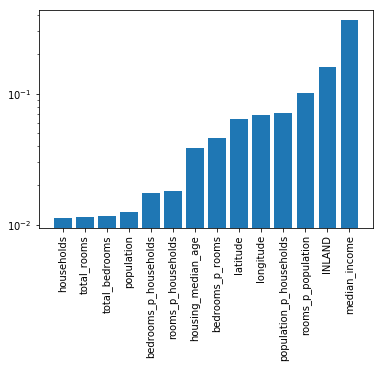

In [22]:
# 重要度を確認
feature_importances = best_estimator.feature_importances_
index = np.array(feature_importances)
index = np.argsort(index)

# plt.bar(list(data2_train), feature_importances)
plt.bar(np.array(list(data2_train))[index], np.array(feature_importances)[index])
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [23]:
results.append(result2)

In [24]:
print(results)

[['data1', 19234.49888783583], ['data2', 19527.449866181865]]


## 重要度が小さい属性を削除してみる

In [25]:
data3_train = data2_train.copy()
data3_label = data2_label.copy()

In [26]:
# 重要度が低い属性の削除
drop_list = ['population', 'total_bedrooms', 'total_rooms', 'households']
data3_train.drop(drop_list, axis=1, inplace=True)
list(data3_train)

['longitude',
 'latitude',
 'housing_median_age',
 'median_income',
 'INLAND',
 'population_p_households',
 'rooms_p_households',
 'bedrooms_p_households',
 'bedrooms_p_rooms',
 'rooms_p_population']

In [27]:
# データ準備
data3_prepared = pipeline_min.fit_transform(data3_train)
# グリッドサーチ
grid_search.fit(data3_prepared, data3_label)
best_estimator = grid_search.best_estimator_
# 計測
data3_predictions = best_estimator.predict(data3_prepared)
data3_mse  = mean_squared_error(data3_label, data3_predictions)
data3_rmse = np.sqrt(data3_mse)
result3 = ['data3', data3_rmse]

print(result3)

['data3', 19145.37117875077]


In [28]:
results.append(result3)

In [29]:
print(results)

[['data1', 19234.49888783583], ['data2', 19527.449866181865], ['data3', 19145.37117875077]]


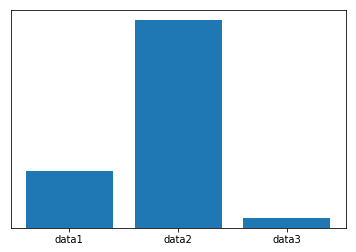

In [30]:
data_plot = np.array(results)
data_plot = data_plot.T
plt.bar(data_plot[0], [float(str) for str in data_plot[1]])
plt.yscale('log')
plt.show()